In [0]:
import numpy as np
from re import sub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, utils, Sequential

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

In [0]:
tf.reset_default_graph()
tf.set_random_seed(42)

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

embedding_size = 512
batch_size = 32
n_hidden_layer = 256
dropout_rate = 0.4
n_epochs = 10
learning_rate = 0.001
val_rate = 0.15

In [0]:
# train dataset source:
# https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label
TRAIN_PATH = '../gdrive/My Drive/train_5500.txt'

# test dataset source:
# https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label
TEST_PATH = '../gdrive/My Drive/test_10.txt'

In [0]:
def universal_sentence_encoder(text):
  # Use universal sentence encoder in NN
  text_as_str = tf.squeeze(tf.cast(text, tf.string), axis=[1])
  return embed(text_as_str, signature="default", as_dict=True)["default"]


def create_model():
  return Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    layers.Lambda(universal_sentence_encoder, output_shape=(embedding_size,)),
    layers.Dense(n_hidden_layer, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(n_classes, activation='softmax')
  ])


def get_dataset(file_path):
  '''
  Args: data file path
  Returns: data frame of the data set,
           array of the data,
           array of one-hot-encoded labels,
           one-hot-encoded labels' columns' names
  '''
  with open(file_path, 'r', encoding='ISO-8859-1') as fp:
    line = fp.readline()
    data = []    
    while line:
      label = line.split(":")[0]
      text = line.split(' ', 1)[1]
      text = sub('[^A-Za-z0-9 ,\?\'\"-._\+\!/\`@=;:]+', '', text)
      data.append([label, text])
      line = fp.readline()

  df = pd.DataFrame(data, columns=['label', 'text'])
  df.label = df.label.astype('category')
  one_hot = pd.get_dummies(df.label])
  return df, df['text'].values[:, np.newaxis], one_hot.values, one_hot.columns.tolist()

In [0]:
df_train, X_train, one_hot_train, classes = get_dataset(TRAIN_PATH)
y_train = df_train.label
df_train.head()

,label,text
0,DESC,How did serfdom develop in and then leave Russ...
1,ENTY,What films featured the character Popeye Doyle ?
2,DESC,How can I find a list of celebrities ' real na...
3,ENTY,What fowl grabs the spotlight after the Chines...
4,ABBR,What is the full form of .com ?


In [0]:
df_test, X_test, one_hot_test, _ = get_dataset(TEST_PATH)
df_test.head()

,label,text
0,NUM,How far is it from Denver to Aspen ?
1,LOC,"What county is Modesto , California in ?"
2,HUM,Who was Galileo ?
3,DESC,What is an atom ?
4,NUM,When did Hawaii become a state ?


In [0]:
print("Classes' counts:")
y_train.value_counts()

Classes' counts:


ENTY    1250
HUM     1223
DESC    1162
NUM      896
LOC      835
ABBR      86
Name: label, dtype: int64

In [0]:
'''
As seen above, the dataset is skewed.
Therefore each class is given a weight where the weight is in inverse ratio to 
the class's size.
Hence, smaller classes have larger weights.
'''
n_classes = len(classes)
weights = class_weight.compute_class_weight('balanced', 
                                            classes,
                                            y_train)
weights_dict = zip(classes, weights)
print("Classes' weights:", *weights_dict, sep='\n')

Classes' weights:
('ABBR', 10.565891472868216)
('DESC', 0.7819850831899025)
('ENTY', 0.7269333333333333)
('HUM', 0.7429817388934314)
('LOC', 1.0882235528942117)
('NUM', 1.0141369047619047)


In [0]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
metrics = ['categorical_accuracy', 'top_k_categorical_accuracy']

model = create_model()

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.train.RMSPropOptimizer(learning_rate), 
              metrics=metrics)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  model.fit(X_train, 
            one_hot_train,
            validation_split=val_rate,
            epochs=n_epochs,
            batch_size=batch_size,
            class_weight=weights_dict,
            callbacks=callbacks)
  model.save_weights('./model.h5')

W0818 13:53:37.230003 140215775754112 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0818 13:53:41.133732 140215775754112 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 4634 samples, validate on 818 samples
Epoch 1/10
4634/4634 [==============================] - 6s 1ms/sample - loss: 1.0384 - categorical_accuracy: 0.6139 - top_k_categorical_accuracy: 0.9691 - val_loss: 1.3384 - val_categorical_accuracy: 0.5660 - val_top_k_categorical_accuracy: 0.9988
Epoch 2/10
4634/4634 [==============================] - 4s 779us/sample - loss: 0.3768 - categorical_accuracy: 0.8789 - top_k_categorical_accuracy: 0.9985 - val_loss: 0.8265 - val_categorical_accuracy: 0.8533 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
4634/4634 [==============================] - 4s 780us/sample - loss: 0.2875 - categorical_accuracy: 0.9027 - top_k_categorical_accuracy: 0.9991 - val_loss: 0.4247 - val_categorical_accuracy: 0.8973 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
4634/4634 [==============================] - 4s 794us/sample - loss: 0.2428 - categorical_accuracy: 0.9180 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2688 - val_categorical_accuracy: 0.9

In [0]:
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  model.load_weights('./model.h5')  
  one_hot_pred = model.predict(X_test, batch_size=batch_size)
  evals = model.evaluate(X_test, one_hot_test)
  
  for name, val in zip(model.metrics_names, evals):
    print(f'{name}: {val:0.3f}')

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f85d6192f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


192/500 [==========>...................] - ETA: 1s - loss: 0.1992 - categorical_accuracy: 0.9323 - top_k_categorical_accuracy: 1.0000

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f85d6192b70>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


500/500 [==============================] - 1s 2ms/sample - loss: 0.1981 - categorical_accuracy: 0.9420 - top_k_categorical_accuracy: 1.0000
loss: 0.198
categorical_accuracy: 0.942
top_k_categorical_accuracy: 1.000


0: ABBR, 1: DESC, 2: ENTY, 3: HUM, 4: LOC, 5: NUM, 

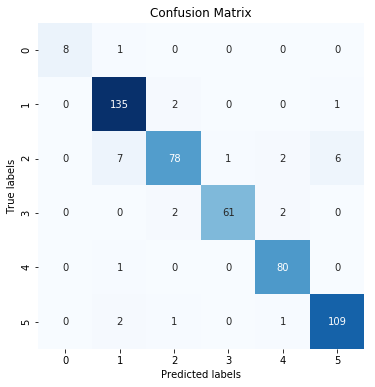

In [0]:
# confusion matrix
y_pred = one_hot_pred.argmax(axis=1)
y_pred_cat = [classes[logit] for logit in y_pred]
conf_mat = confusion_matrix(df_test.label, y_pred_cat, labels=classes)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, square=True, annot=True, 
            cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

for i, cat in enumerate(classes):
  print(f'{i}: {cat}', end=', ')